# Data Forecasting with prophet


# PROPHET PREDICTION

## TESTO

## Import Dependencies

In [1]:
!pip3 install chart_studio
!pip3 install pystan
!pip3 install fbprophet
!pip3 install glob2
!pip3 install python-dateutil

^C
^C


In [1]:
import os
import itertools
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import datetime 
from datetime import timedelta
import math
import numpy as np
import scipy.stats as st
from prophet import Prophet
from influxdb_client import InfluxDBClient
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

In [2]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)


In [3]:
def convert_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)

In [4]:
buckets = [ 'temperature', 'humidity', 'gas']

In [12]:
#With this function we obtain the forecasted data

def bucket_forecast(bucket,i):
    global mse_array
    global forecasted_array
    global expected_array
    global forecasted
    global expected
    global forecast

    mse_array = []
    forecasted_array = []
    expected_array = []
    forecasted = []
    expected = []
    path = ["../datasets/temperature.csv", "../datasets/Humidity.csv", "../datasets/Gas.csv"]
    
    print(bucket)
    query = 'from(bucket: "'+ bucket +'")' \
                ' |> range(start:-30d)'\
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "' + bucket +'")' \
                ' |> aggregateWindow(every: 3m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    # result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    # Convert the results to dataframe
    dataset_path = open(path[i])
    df = pd.read_csv(dataset_path)
    #df = convert_to_dataframe(result)
    print(df)
    
    df['ds'] = pd.to_datetime(df['ds'])
    df['ds'] = df['ds'].dt.tz_localize(None)
    
    #train_size 80% - test_size 20%

    train, test = train_test_split(df, test_size=0.2, shuffle=False)
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=30,
        n_changepoints=35,
        changepoint_range=1,
        changepoint_prior_scale=0.01
    ).fit(train)
    
    test_interval = int((test.iloc[-1]['ds'].timestamp() - test.iloc[0]['ds'].timestamp()) / 60)
    test_interval = test_interval + 5
    #print(test_interval)

    future = m.make_future_dataframe(periods=60*12, freq= DateOffset(minutes=1))
    forecast = m.predict(future)

    forecast['ds'] = forecast.ds.dt.floor('min')
    test['ds'] = test.ds.dt.floor('min')
    metric = test.set_index('ds')[['y']].join(forecast.set_index('ds').yhat).reset_index()

    metric = metric.dropna()
    
    mse = mean_squared_error(metric['y'], metric['yhat'])
    mse_array.append(mse)
    
    expected_array.append(metric['y'].tolist())
    forecasted_array.append(metric['yhat'].tolist())
    forecasted = list(itertools.chain.from_iterable(forecasted_array))
    expected = list(itertools.chain.from_iterable(expected_array))

    

# evaluate_field('temp')
# print(mse_array)
# print(sum(mse_array)/len(mse_array))

In [13]:
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

temperature
                                   ds     y
0      2022-11-07T09:19:55.576000041Z  23.0
1      2022-11-07T09:20:18.296123334Z  16.4
2      2022-11-07T09:20:20.851790209Z  16.1
3      2022-11-07T09:20:23.308454584Z  16.1
4      2022-11-07T09:20:25.868063834Z  16.1
...                               ...   ...
18620  2022-11-08T22:13:03.470645208Z  17.5
18621  2022-11-08T22:28:13.499101042Z  17.5
18622  2022-11-08T22:43:33.508575792Z  17.4
18623    2022-11-08T22:59:07.5065885Z  17.4
18624  2022-11-08T22:59:08.518524792Z  17.4

[18625 rows x 2 columns]


19:45:37 - cmdstanpy - INFO - Chain [1] start processing
19:47:20 - cmdstanpy - INFO - Chain [1] done processing




Evaluating temperature


C:\Users\andre\AppData\Local\Temp\ipykernel_17776\4089324538.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = test.ds.dt.floor('min')


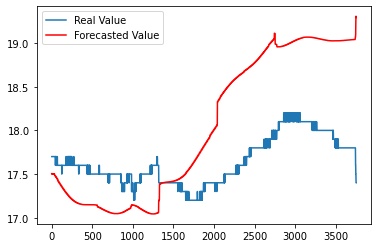

mse
0.571432881690165
Test RMSE: 0.756
MAE: 0.657126
Mean:  18.03490967624837
Standard Deviation:  0.8232933153084975
Confidence intervals:  (18.00855780942155, 18.06126154307537)
humidity
                                   ds     y
0      2022-11-07T09:19:55.577661084Z  52.6
1      2022-11-07T09:20:18.297219084Z  56.6
2      2022-11-07T09:20:20.852867667Z  56.7
3        2022-11-07T09:20:23.3090375Z  56.9
4      2022-11-07T09:20:25.870717292Z  57.0
...                               ...   ...
18620    2022-11-08T22:13:03.4710345Z  64.4
18621  2022-11-08T22:28:13.503724375Z  64.4
18622  2022-11-08T22:43:33.514910167Z  64.6
18623  2022-11-08T22:59:07.507274542Z  64.6
18624  2022-11-08T22:59:08.518886542Z  64.5

[18625 rows x 2 columns]


19:47:31 - cmdstanpy - INFO - Chain [1] start processing
19:48:45 - cmdstanpy - INFO - Chain [1] done processing




Evaluating humidity


C:\Users\andre\AppData\Local\Temp\ipykernel_17776\4089324538.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = test.ds.dt.floor('min')


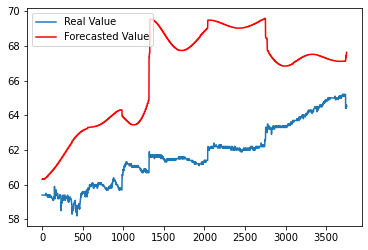

mse
25.37020423231461
Test RMSE: 5.037
MAE: 4.597277
Mean:  66.33902983299771
Standard Deviation:  2.7090990830938355
Confidence intervals:  (66.25231733706109, 66.42574232893496)
gas
                                   ds    y
0      2022-11-07T09:19:55.577725667Z  750
1      2022-11-07T09:20:18.298704792Z  325
2      2022-11-07T09:20:20.853741709Z  212
3         2022-11-07T09:20:23.309194Z  192
4      2022-11-07T09:20:25.871001584Z  192
...                               ...  ...
18620  2022-11-08T22:13:03.471116083Z  113
18621  2022-11-08T22:28:13.503803375Z  144
18622  2022-11-08T22:43:33.518171167Z  167
18623   2022-11-08T22:59:07.50736675Z   89
18624  2022-11-08T22:59:08.518958292Z   95

[18625 rows x 2 columns]


19:48:57 - cmdstanpy - INFO - Chain [1] start processing
19:49:07 - cmdstanpy - INFO - Chain [1] done processing




Evaluating gas


C:\Users\andre\AppData\Local\Temp\ipykernel_17776\4089324538.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = test.ds.dt.floor('min')


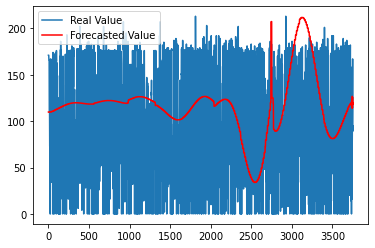

mse
3452.955366915541
Test RMSE: 58.762
MAE: 47.963241
Mean:  115.86684117387891
Standard Deviation:  31.967512620435336
Confidence intervals:  (114.84362913061655, 116.89005321714181)


In [15]:
APE = []
i = 0
for bucket in buckets:
	bucket_forecast(bucket,i)
	print("\n\nEvaluating " + bucket)
	plt.plot(expected, label="Real Value")
	plt.plot(forecasted, "-r", label="Forecasted Value")

	plt.legend(loc="upper left")
	plt.show()

	#Mean Square Error & Root Square Error considered more accurate 
	mse = mean_squared_error(expected, forecasted)
	print('mse')
	print(mse) #mah
	rmse = math.sqrt(mean_squared_error(expected, forecasted))
	print('Test RMSE: %.3f'%rmse)

	
	# MAE
	# The mean absolute error, or MAE, 
	# is calculated as the average of the forecast error values, 
	# where all of the forecast error values are forced to be positive.
	# These error values are in the original units of the predicted values. 
	# A mean absolute error of zero indicates no error.

	# Calculate the MAE 
	mae = mean_absolute_error(expected, forecasted)
	print('MAE: %f' % mae)


	# A confidence interval is an estimation technique used in statistical inference to constrain a pair or pairs of values, 
	# within which the desired point estimate will be found (with a certain probability).

	# A confidence interval will allow us to calculate two values around a sample mean (one upper and one lower). 
	# These values will bound an interval within which, with some probability, the population parameter will be found.


	mean = sum(forecasted) / len(forecasted) #mean
	print("Mean: ",mean)


	std = np.std(forecasted)  # standard deviation
	print("Standard Deviation: ",std)

	# create 95% confidence interval
	res = st.t.interval(alpha=0.95, df=len(forecasted)-1,
				loc=np.mean(forecasted),
				scale=st.sem(forecasted))

	print("Confidence intervals: ",res)

	'''lines = [str(forecast["yhat"][d]) for d in range(len(forecast))]
	print(lines)
	lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(forecast["yhat"][d])
									+ ' ' + str(int(time.mktime(forecast['ds'][d].timetuple())) + 3600*2) + "000000000" for d in range(len(forecast))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)'''
	i+=1